# Popular Data Science Questions

The goal of this project is to figure out the best topic to write about for a company that creates data science content. We will investigate popular topics posted on the Data Science Stack Exchange (DSSE). 

DSSE  is a data science dedicated site and ranks in the bottom 10 in percentage of questions answered. This may indicate an opportunity to write content on data science topics.

## Stack Exchange Features

Before we go deeper, it is important to have a basic understanding of how a Stack Exchange site works. 

A Stack Exchange site is a question-answer site dedicated to a topic in a variety of categories, such as technology, culture, language, science, recreation, professional, and business.

On the home page we can see that we have four sections:

* Questions — a list of all questions asked
* Tags — a list of tags (keywords or labels that categorize questions)
* Users — a list of users
* Unanswered — a list of unanswered questions

Each question page has additional elements besides the question itself:

* upvote / downvote icons
* Number of views
* Comments from other users that are tied to the question - usually requests for additional information or clarification
* Answers from other users intending to answer the question at hand


The tagging system used by Stack Exchange looks just like what we need to solve this problem as it allow us to quantify how many questions are asked about each subject.

Something else we can learn from exploring the help center, is that Stack Exchange's sites are heavily moderated by the community; this gives us some confidence in using the tagging system to derive conclusions.

We can keep things simple and analyze tags by the following criteria:

* Number of tag appearances (Frequency of tags)
* Number of views 

## Stack Exchange Data Explorer

Stack Exchange provides a public data base for each of its websites. 

For this projet, we shall pull the data for the DESE site using the Stack Exchange Data Explorer (SEDE). The SEDE uses a built in SQL query system for pulling data from the site.

We have data for questions posted in 2019 and also a dataset for all questions posted which go back to 2015. 

Perusing the table names, a few stand out as relevant for our goal:

* Posts
* PostTags
* Tags
* TagSynonyms

We shall explore and query a few of the tables at the link: https://data.stackexchange.com/datascience/query/new

Running a few exploratory queries, leads us to focus our efforts on Posts table. The Tags table looked very promising as it tells us how many times each tag was used, but there's no way to tell just from this if the interest in these tags is recent or a thing from the past.

Looking through the posts table, we will be foussing our attantion on the following columns. These will be useful for finding the most common posts and topics on the Data Science site.

* Id: An identification number for the post.
* PostTypeId: An identification number for the type of post.
* CreationDate: The date and time of creation of the post.
* Score: The post's score.
* ViewCount: How many times the post was viewed.
* Tags: What tags were used.
* AnswerCount: How many answers the question got (only applicable to question posts).
* FavoriteCount: How many times the question was favored (only applicable to question posts).

For this project, we shall focus on question posts which are referred by PostTypeID = 1.

Also, our focus will be in recent posts, hence, we'll limit our analysis to the posts of 2019

The data for this is stored in a file called 2019_questions.csv. We shall be using this file for our analysis, henceforth

In [2]:
import pandas as pd

data_q = pd.read_csv("2019_questions.csv", parse_dates  = ['CreationDate'])
data_q.head()

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,44419,2019-01-23 09:21:13,1,21,<machine-learning><data-mining>,0,NaN
1,44420,2019-01-23 09:34:01,0,25,<machine-learning><regression><linear-regressi...,0,NaN
2,44423,2019-01-23 09:58:41,2,1651,<python><time-series><forecast><forecasting>,0,NaN
3,44427,2019-01-23 10:57:09,0,55,<machine-learning><scikit-learn><pca>,1,NaN
4,44428,2019-01-23 11:02:15,0,19,<dataset><bigdata><data><speech-to-text>,0,NaN


In [3]:
data_q.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
Id               8839 non-null int64
CreationDate     8839 non-null datetime64[ns]
Score            8839 non-null int64
ViewCount        8839 non-null int64
Tags             8839 non-null object
AnswerCount      8839 non-null int64
FavoriteCount    1407 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 483.5+ KB


We can observe that there are multiple nullvalues in faourite count. A plausible explanation for this would be that the question was not present in any users' favorite list. So we can replace the missing values with zero. 

Once, the missing values are filled with zero, we can easily convert the column to integer type.

Let us now check the Tags column which is of data type object.
We shall check what the individual items are stored as in the Tags column

In [4]:
data_q["Tags"].apply(lambda v: type(v)).unique()

array([<class 'str'>], dtype=object)

From the code above, we can see that each item in Tags is a string item. 

We shall clean them and present the data in a clean manner.

## Cleaning The Data

We shall start by filling the columns for FavoriteCount

In [5]:
data_q["FavoriteCount"] = data_q["FavoriteCount"].fillna(0)

Next, we are going to simplify and clean the Tags column and make it more presentable

In [6]:
data_q["Tags"] = data_q["Tags"].str.replace('><', ',')
data_q["Tags"] = data_q["Tags"].str.replace('<', '')
data_q["Tags"] = data_q["Tags"].str.replace('>', '')
data_q["Tags"] = data_q["Tags"].str.split(',')
data_q.head()

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,44419,2019-01-23 09:21:13,1,21,"[machine-learning, data-mining]",0,0.0
1,44420,2019-01-23 09:34:01,0,25,"[machine-learning, regression, linear-regressi...",0,0.0
2,44423,2019-01-23 09:58:41,2,1651,"[python, time-series, forecast, forecasting]",0,0.0
3,44427,2019-01-23 10:57:09,0,55,"[machine-learning, scikit-learn, pca]",1,0.0
4,44428,2019-01-23 11:02:15,0,19,"[dataset, bigdata, data, speech-to-text]",0,0.0


## Most Used and Most Viewed

We shall now focus on determining the most popular tag.

For each tag we'll count how many times the tag was used, and how many times a question with that tag was viewed.

Let us start by counting how many times each tag was used

In [7]:
no_tag = {}
for t in data_q["Tags"]:
    for tag in t:
        if tag in no_tag:
            no_tag[tag] +=1
        else:
            no_tag[tag] = 1

Let us convert this data into a Series.

In [8]:
most_used = pd.Series(no_tag, name = "Count")
most_used.head()

.net                    1
3d-object-detection     1
3d-reconstruction       9
ab-test                 6
accuracy               89
Name: Count, dtype: int64

The first tag in the listis a blank tag. We shall drop that value  and filter the top 20 most commonly used tags

In [9]:
most_used_top20 = most_used.sort_values(ascending = False).head(20)
most_used_top20

machine-learning          2693
python                    1814
deep-learning             1220
neural-network            1055
keras                      935
classification             685
tensorflow                 584
scikit-learn               540
nlp                        493
cnn                        489
time-series                466
lstm                       402
pandas                     354
regression                 347
dataset                    340
r                          268
predictive-modeling        265
clustering                 257
statistics                 234
machine-learning-model     224
Name: Count, dtype: int64

We shall now create a bar plot showing the most used tags

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

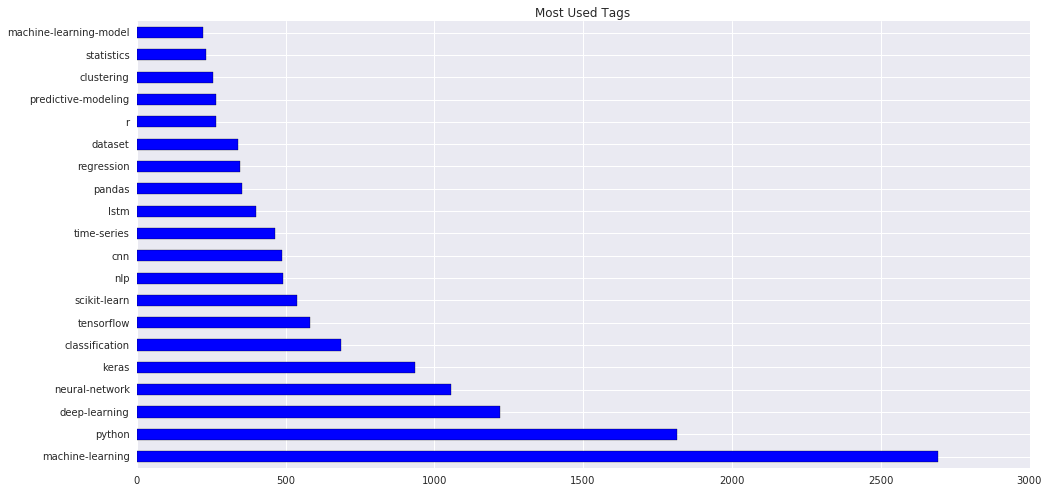

In [11]:
p = most_used_top20.plot(kind ="barh",color = "b", figsize = (16,8))
p.set_title("Most Used Tags")

From the graph above, we can see that the most popular tag by far is machine learning. This is followed by python, deep learnig ad neural networks which are quite popular as well. Let us now check the most viewed tags.

Next, we shall check how many times each tag was viewed.

In [12]:
tag_view = {}
for index,t in data_q.iterrows():
    for tag in t["Tags"]:
        if tag in tag_view:
            tag_view[tag] += t["ViewCount"]
        else:
            tag_view[tag] = t["ViewCount"]


Again, we shall convert this to a Series

In [13]:
most_viewed = pd.Series(tag_view, name = "Views")
most_viewed.sort_values(ascending = False).head()

python              537585
machine-learning    388499
keras               268608
deep-learning       233628
pandas              201787
Name: Views, dtype: int64

Again, we shall apply the same method as before on the most viewed tags

In [14]:

most_viewed_top20 = most_viewed.sort_values(ascending = False).head(20)
most_viewed_top20

python              537585
machine-learning    388499
keras               268608
deep-learning       233628
pandas              201787
neural-network      185367
scikit-learn        128110
tensorflow          121369
classification      104457
dataframe            89352
lstm                 74458
nlp                  71382
cnn                  70349
time-series          64134
numpy                49767
regression           49451
dataset              43151
pytorch              40240
csv                  38654
clustering           33928
Name: Views, dtype: int64

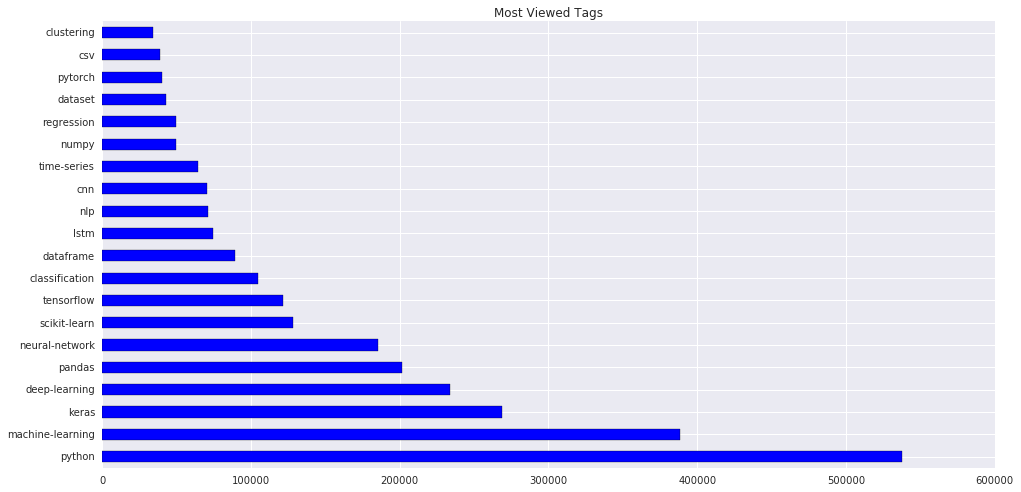

In [15]:
p = most_viewed_top20.plot(kind ="barh",color = "b", figsize = (16,8))
p.set_title("Most Viewed Tags")

In terms of views, python has the highest number of views followed by machine learning and keras

On comparing the number of views and number of uses, machine learning and python seem to be the most popular tags. This is not surprising as apart from being popular topics in data science, these tags also relate to a broad umbrella of topics, especially python which in iteslf covers a wide range of topics

Also, if we look at the top results in both most used and most viewed tags, the common ones are 
* python 
* machine-learning 
* deep-learning
* neural-network
* keras
* tensorflow
* classification
* scikit-learn.

Of these,Keras, scikit-learn and TensorFlow are all Python libraries that allow their users to employ deep learning

In fact, most of the top tags are related with deep learning. 
Knowig this, we can suggest the creation of Python content that uses deep learning for classification problems 

## Is deep learning just a fad?

Before confirming our recommendation, we would like to confirm whether the interest in deep learning is just a teporary phase. In other words, we would like to determine whether interest in deep learning be slowing down

To achieve this, we shall track the interest in deep learning across time.

We shall use the all_questions dataset and find out the following:

* Count how many deep learning questions are asked per time period.
* The total amount of questions per time period.
* How many deep learning questions there are relative to the total amount of questions per time period.
    

In [16]:
deep_q = pd.read_csv("all_questions.csv", parse_dates = ["CreationDate"])
deep_q["Tags"] = deep_q["Tags"].str.replace('><', ',')
deep_q["Tags"] = deep_q["Tags"].str.replace('<', '')
deep_q["Tags"] = deep_q["Tags"].str.replace('>', '')
deep_q["Tags"] = deep_q["Tags"].str.split(',')
deep_q.head()


,Id,CreationDate,Tags
0,45416,2019-02-12 00:36:29,"[python, keras, tensorflow, cnn, probability]"
1,45418,2019-02-12 00:50:39,[neural-network]
2,45422,2019-02-12 04:40:51,"[python, ibm-watson, chatbot]"
3,45426,2019-02-12 04:51:49,[keras]
4,45427,2019-02-12 05:08:24,"[r, predictive-modeling, machine-learning-mode..."


To decide which questions are related to deep learning, we shall need to consider which tags are deep learning tags.

The definition of what constitutes a deep learning tag we'll use is: a tag that belongs to the list ["lstm", "cnn", "scikit-learn", "tensorflow", "keras", "neural-network", "deep-learning"].

This list was obtained by looking at all the tags in most_used and seeing which ones had any relation to deep learning.

We shall now add a column which takes the value True if it is a deep learning question and false if it is not

In [17]:
def classify(tags):
     for tag in tags:
        if tag in ["lstm", "cnn", "scikit-learn", "tensorflow",
                   "keras", "neural-network", "deep-learning"]:
            return True
     return False
        

In [18]:
deep_q["Deep Learning"] = deep_q["Tags"].apply(classify)
deep_q.head()

,Id,CreationDate,Tags,Deep Learning
0,45416,2019-02-12 00:36:29,"[python, keras, tensorflow, cnn, probability]",True
1,45418,2019-02-12 00:50:39,[neural-network],True
2,45422,2019-02-12 04:40:51,"[python, ibm-watson, chatbot]",False
3,45426,2019-02-12 04:51:49,[keras],True
4,45427,2019-02-12 05:08:24,"[r, predictive-modeling, machine-learning-mode...",False


We shall now analyse the yearly average usage of tags or deep learning.

In [19]:
deep_q["Year"] = deep_q["CreationDate"].dt.year

As the data for year 2020 is incomplete in the set, se shall remove that data from our dataset

In [20]:
deep_q = deep_q[deep_q["Year"]<2020]

In [21]:
yearly_trend = deep_q.pivot_table(index = "Year", values = "Deep Learning", 
                                  aggfunc = ('sum', 'size'))
yearly_trend.columns = ['TotalQuestions','DeepLearningQuestions']
yearly_trend["Deep Learning Percentage"] = round(yearly_trend['DeepLearningQuestions']/yearly_trend["TotalQuestions"]* 100, 2)
yearly_trend.reset_index(level = 0, inplace = True)

In [22]:
yearly_trend

,Year,TotalQuestions,DeepLearningQuestions,Deep Learning Percentage
0,2014,562,43.0,7.65
1,2015,1167,157.0,13.45
2,2016,2146,557.0,25.96
3,2017,2957,1068.0,36.12
4,2018,5475,2336.0,42.67
5,2019,8810,3489.0,39.60


It seems the deep learning questions have seen a gradually increasing trend in our. Let us now plot our findings in a graph to show the trend cleary.

In [23]:
plt.bar(x= yearly_trend["Year"], y = yearly_trend["Deep Learning Percentage"], color = 'b', figsize = (12,8))
plt.set_title("Deep Learning Trends")
plt.set_ylabel("Percentage")

TypeError: bar() missing 2 required positional arguments: 'left' and 'height'

## Conclusion

From the above graph, we can conclude that the growth of deep learning, which is a subset of machine learning is not just a fad. The popularity of both deep learning has increased each year from 2014 onwards. Also, from the previous analysis, we have seen that Python is another popular topic among data science enthusiasts. 

These were the 2 most popular topics in the Data Science community and have been shown to be the most popular from 2014 onwards.

I am happy to recommend 2 topics for the Data Science Content company. 

Deep Learning and Python.